In [1]:
from config import init_env, settings
init_env(name='cls_gte_xgb_norm')
settings.MODEL_NAME = 'Alibaba-NLP/gte-base-en-v1.5'
settings.MODELS_PATH

CUDA is available, using GPU NVIDIA GeForce RTX 3090 x4


PosixPath('../models/cls_gte_xgb_norm')

In [6]:
from typing import Optional, List
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from config import settings

class SentenceDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        inputs = self.tokenizer(sentence, return_tensors="pt", max_length=self.max_length, 
                                padding="max_length", truncation=True)
        return inputs


class SentenceEmbedder:
    def __init__(
            self,
            model_name: Optional[str] = None,
            # dtype: Optional[torch.dtype] = None,
            batch_size: int = 32,
            max_length: int = 128,
    ):
        assert hasattr(settings, "TORCH_DEVICE"), "run init_env() first"
        if model_name is None:
            model_name = settings.rngen.embed_model
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        if settings.TORCH_DEVICE.type != 'cpu':
            model = model.to(settings.TORCH_DEVICE)
        # if dtype is not None:
        #     model = model.to(dtype=dtype)
        model.eval()

        self.model = model
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_length = max_length

    def encode(self, sentences: List[str]) -> pd.DataFrame:
        dataset = SentenceDataset(sentences, self.tokenizer, self.max_length)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        embeddings = []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Generating embeddings"):
                input_ids = batch['input_ids'].to(settings.TORCH_DEVICE).squeeze()
                attention_mask = batch['attention_mask'].to(settings.TORCH_DEVICE).squeeze()
                # Enables autocasting for the forward pass (model + loss)
                with torch.autocast(device_type=settings.TORCH_DEVICE.type):
                    outputs = self.model(input_ids, attention_mask=attention_mask)
                    _emb = outputs.last_hidden_state[:, 0]
                    # l2 normalization
                    _emb = F.normalize(_emb, p=2, dim=1)
                # numpy doesn't support bfloat16
                embeddings.append(_emb.cpu().detach().numpy())

        df_embs = pd.DataFrame(
            np.vstack(embeddings), 
            columns=[f'emb{i}' for i in range(embeddings[0].shape[1])]
        )
        return df_embs
    
model_embed = SentenceEmbedder(
    model_name=settings.MODEL_NAME,
    batch_size=32,
    max_length=128,
)

In [7]:
import pandas as pd

df_commits = pd.read_parquet(settings.DATASETS_PATH / 'dataset_cls.parquet')
df_repos = pd.read_csv(settings.DATASETS_PATH / 'repos_cls.csv', on_bad_lines='skip')
print(df_commits.shape, df_repos.shape)
df_commits

(715089, 458) (406, 14)


,nameWithOwner,sha,authorName,authorEmail,date,releaseTag,nFiles,addLines,delLines,lang1CEnterprise,...,avgHistoryComplexity,commits,contributors,stars,issues,prs,comments,type,isInRN,domain
0,ibotpeaches/apktool,841db5061afdb50c010bb79240bfe67c567873b6,Connor Tumbleson,connor.tumbleson@gmail.com,2024-01-05 11:29:04+00:00,v2.9.3,1,1,1,False,...,32.693333,2196,96,19195,1902,550,7814,build,False,Tool
1,ibotpeaches/apktool,f56de45f381d3d09968f7f9f74d5821ec7560b0a,Connor Tumbleson,connor.tumbleson@gmail.com,2024-01-05 11:28:51+00:00,v2.9.2,1,2,2,False,...,6.342727,2189,96,19090,1900,546,7804,build,False,Tool
2,ibotpeaches/apktool,077b2009da671515ec1c86ba6d4c19e4100e18b0,Connor Tumbleson,connor.tumbleson@gmail.com,2023-12-05 23:26:28+00:00,v2.9.2,1,1,1,False,...,6.342727,2189,96,19090,1900,546,7804,build,False,Tool
3,ibotpeaches/apktool,98b34fdd03db825390b426bb1200b8515c001e22,dependabot[bot],49699333+dependabot[bot]@users.noreply.github.com,2023-12-04 11:08:40+00:00,v2.9.1,2,3,3,False,...,1.927742,2156,95,18869,1889,537,7736,build,False,Tool
4,ibotpeaches/apktool,aa3bd84ceb7d17f6379fe1796bb28598d243d763,dependabot[bot],49699333+dependabot[bot]@users.noreply.github.com,2023-12-04 11:07:01+00:00,v2.9.1,1,1,1,False,...,1.927742,2156,95,18869,1889,537,7736,build,False,Tool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715084,apache/apisix,588d46ff18248f0bc616425bc162e9ba4862f4da,wonglend,gk.wl@qq.com,2020-07-07 02:36:32+00:00,1.5,1,1,1,False,...,0.497284,42,10,80,16,23,119,fix,False,System
715085,apache/apisix,2ccf0200279b7c8a10edbb3ef867e52a7537dbbc,YuanSheng Wang,membphis@gmail.com,2020-07-02 14:04:24+00:00,1.5,3,6,4,False,...,0.497284,42,10,80,16,23,119,test,False,System
715086,apache/apisix,d419fb22894214e4ef1c1ccfb1ffdaca3dff3fca,YuanSheng Wang,membphis@gmail.com,2020-06-24 01:59:11+00:00,1.5,1,66,0,False,...,0.497284,42,10,80,16,23,119,test,False,System
715087,apache/apisix,e30a7469bcee27ab3422ab6d6b0b8044e2b20588,YuanSheng Wang,membphis@gmail.com,2020-06-23 10:21:08+00:00,1.5,1,1,1,False,...,0.497284,42,10,80,16,23,119,test,False,System


In [8]:
import numpy as np
import torch
import os
from tqdm.auto import tqdm

if os.path.exists(settings.CACHE_PATH / 'df_embs.parquet'):
    df_embs = pd.read_parquet(settings.CACHE_PATH / 'df_embs.parquet')
    print(df_embs.shape)
else:
    df_embs = model_embed.encode(df_commits['body'].tolist())
df_embs

Generating embeddings:   0%|          | 0/22347 [00:00<?, ?it/s]

,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,...,emb758,emb759,emb760,emb761,emb762,emb763,emb764,emb765,emb766,emb767
0,0.024181,-0.013148,-0.004729,0.012958,0.016061,0.007164,0.072688,-0.064114,0.019823,-0.028826,...,-0.012041,0.005869,-0.054242,-0.007133,0.006949,0.002313,-0.051331,-0.015611,-0.032503,0.016994
1,0.019930,-0.028540,-0.000158,0.019081,0.069934,0.038530,0.033957,-0.007876,-0.000758,-0.003532,...,-0.003758,-0.001288,-0.016643,-0.062957,-0.007724,0.010153,0.022253,-0.057390,0.032337,0.012098
2,0.010009,-0.014955,-0.008285,-0.008144,0.025314,0.012224,0.077882,-0.050526,0.026437,-0.035478,...,-0.010385,0.010157,-0.059134,-0.012631,0.018230,0.001386,-0.051122,-0.022794,-0.023788,0.016637
3,0.012378,-0.002521,-0.033601,0.019440,0.002199,0.009201,0.023789,-0.056001,0.034113,-0.028761,...,-0.034258,-0.014627,-0.019684,-0.075042,0.035727,-0.006184,-0.000835,-0.012766,-0.028496,0.023180
4,0.037512,-0.015493,-0.007008,0.048673,0.009783,0.016538,-0.013101,-0.047497,-0.032275,-0.053946,...,-0.048392,-0.000095,-0.017819,-0.019142,0.017976,0.020044,-0.022333,-0.026665,-0.004873,0.016992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715084,0.042141,-0.015373,-0.069148,-0.078251,-0.045430,-0.012624,0.000732,-0.042953,-0.009405,-0.018268,...,0.018378,0.011264,0.064326,0.003049,-0.001897,0.002875,0.003626,-0.015308,-0.031382,-0.015569
715085,-0.009251,-0.017179,-0.041633,-0.028559,-0.049138,0.023944,0.041024,-0.011317,-0.024704,-0.031697,...,-0.011345,0.014648,-0.079588,0.032558,-0.021979,0.014707,-0.030081,0.025358,-0.023598,0.004850
715086,0.017718,-0.010696,0.015859,-0.028895,0.068472,-0.033432,0.021085,0.034672,-0.033415,-0.000494,...,0.034593,-0.014389,-0.040290,-0.001793,0.010686,-0.032363,0.039446,0.005448,0.021545,-0.009400
715087,0.030694,-0.038207,-0.026564,0.005255,-0.016833,-0.020239,-0.034088,-0.010945,0.058062,-0.075356,...,0.001970,0.006615,-0.016967,-0.030852,-0.022122,-0.007011,-0.042674,0.025406,0.018463,0.025692


In [9]:
# naive split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# _df_cls = pd.read_parquet('../temp/cls_bge_emb.parquet')
df_ds = pd.concat([df_commits, df_embs], axis=1)\
    .drop(columns=['nameWithOwner', 'sha', 'authorName', 'authorEmail', 'date', 'releaseTag', 'body', 'isInRN'])

_encoder_type = LabelEncoder()
_encoder_type.fit(settings.categories.conventional_commits)
df_ds['type'] = pd.Series(_encoder_type.transform(df_ds['type'])).astype('category')

_encode_releaseType = LabelEncoder()
_encode_releaseType.fit(settings.categories.release_types)
df_ds['releaseType'] = pd.Series(_encode_releaseType.transform(df_ds['releaseType'])).astype('category')

_encoder_domain = LabelEncoder()
_encoder_domain.fit(settings.categories.project_domains)
df_ds['domain'] = pd.Series(_encoder_domain.transform(df_ds['domain'])).astype('category')

ds_train, ds_test = train_test_split(
    df_ds, test_size=0.3, random_state=settings.seed, stratify=df_ds['type']
)
ds_test, ds_valid = train_test_split(
    ds_test, test_size=0.33, random_state=settings.seed, stratify=ds_test['type']
)

# ds_train.to_parquet('../temp/cls_train.parquet')
# ds_test.to_parquet('../temp/cls_test.parquet')
# ds_valid.to_parquet('../temp/cls_valid.parquet')

X_train, y_train = ds_train.drop(columns=['type']), ds_train['type']
X_test, y_test = ds_test.drop(columns=['type']), ds_test['type']
X_valid, y_valid = ds_valid.drop(columns=['type']), ds_valid['type']

print(ds_train.shape, ds_test.shape, ds_valid.shape)

(500562, 1218) (143733, 1218) (70794, 1218)


In [10]:
import xgboost as xgb
from sklearn.metrics import classification_report
import json

clf = xgb.XGBClassifier(
        objective="multi:softmax",
        tree_method="hist", 
        enable_categorical=True, 
        device="cuda",
        eval_metric="mlogloss",
        random_state=settings.SEED,
        early_stopping_rounds=10,
    )
clf.fit(
    X_train.values, y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    verbose=True,
)
clf.save_model(settings.MODELS_PATH / 'cls_gte_xgb_split.json')
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
with open(settings.MODELS_PATH / 'cls_gte_xgb_split.perf.json', 'w') as f:
    json.dump(classification_report(y_test, y_pred, output_dict=True), f)

[0]	validation_0-mlogloss:1.91027
[1]	validation_0-mlogloss:1.69377
[2]	validation_0-mlogloss:1.55243
[3]	validation_0-mlogloss:1.44908
[4]	validation_0-mlogloss:1.37162
[5]	validation_0-mlogloss:1.31133
[6]	validation_0-mlogloss:1.26321
[7]	validation_0-mlogloss:1.22390
[8]	validation_0-mlogloss:1.19021
[9]	validation_0-mlogloss:1.16304
[10]	validation_0-mlogloss:1.13918
[11]	validation_0-mlogloss:1.11804
[12]	validation_0-mlogloss:1.10111
[13]	validation_0-mlogloss:1.08514
[14]	validation_0-mlogloss:1.07139
[15]	validation_0-mlogloss:1.05829
[16]	validation_0-mlogloss:1.04704
[17]	validation_0-mlogloss:1.03549
[18]	validation_0-mlogloss:1.02564
[19]	validation_0-mlogloss:1.01755
[20]	validation_0-mlogloss:1.00926
[21]	validation_0-mlogloss:0.99986
[22]	validation_0-mlogloss:0.99044
[23]	validation_0-mlogloss:0.98420
[24]	validation_0-mlogloss:0.97745
[25]	validation_0-mlogloss:0.97209
[26]	validation_0-mlogloss:0.96650
[27]	validation_0-mlogloss:0.96208
[28]	validation_0-mlogloss:0.9

/raid/hrz/smartdraft/.pixi/envs/default/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:44:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.91      0.65      0.76      4746
           1       0.76      0.77      0.76     40960
           2       0.67      0.43      0.52      1946
           3       0.78      0.77      0.77     13955
           4       0.66      0.64      0.65     23203
           5       0.68      0.80      0.73     45149
           6       0.63      0.19      0.29       838
           7       0.55      0.33      0.42      7375
           8       0.86      0.04      0.08       139
           9       0.65      0.23      0.34       784
          10       0.61      0.48      0.54      4638

    accuracy                           0.71    143733
   macro avg       0.71      0.48      0.53    143733
weighted avg       0.71      0.71      0.70    143733



In [11]:
# sample 100, check the uncorrectly classified
_sampled = ds_test.sample(100, random_state=settings.SEED)
_sampled['type'] = _encoder_type.inverse_transform(_sampled['type'])
_predicted = clf.predict(_sampled.drop(columns=['type']))
_predicted = _encoder_type.inverse_transform(_predicted)
_sampled['predicted'] = _predicted
_sampled['body'] = df_commits['body'][_sampled.index]
_sampled['url'] = 'https://github.com/' + df_commits['nameWithOwner'][_sampled.index] + '/commit/' + df_commits['sha'][_sampled.index]
_df = _sampled[_sampled['predicted'] != _sampled['type']][['url','body','type','predicted']]
# print in markdown format
print(_df.to_markdown(index=False))

| url                                                                                                  | body                                                                               | type     | predicted   |
|:-----------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------|:---------|:------------|
| https://github.com/pnpm/pnpm/commit/78aa2748d1edb5aca2c0cf8eeb33a4d0927ac415                         | update @types/ramda to version 0.0.4                                               | fix      | chore       |
| https://github.com/feathersjs/feathers/commit/f25c88bb86459989112d95f0eb4d3b2028b0bb56               | Clean up hooks code (#1407)                                                        | fix      | refactor    |
| https://github.com/lerna/lerna/commit/59d71463f2203bda33feeb0452e2ecf068f99922                       | fix init test (#3708)              

In [12]:
# k-fold cross validation
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import json

settings.KFOLD_SPLITS = 5

X, y = df_ds.drop(columns=['type']), df_ds['type']
skf = StratifiedKFold(n_splits=settings.KFOLD_SPLITS, shuffle=True, random_state=settings.SEED)

_metrics = []
_loss = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print('fold', i+1, 'of', settings.KFOLD_SPLITS, ', inputs:', X_train.shape, X_test.shape)
    clf = xgb.XGBClassifier(
        objective="multi:softmax",
        tree_method="hist", 
        enable_categorical=True, 
        device="cuda",
        eval_metric="mlogloss",
        early_stopping_rounds=10,
        random_state=settings.SEED,
    )
    clf.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=True,
    )
    clf.save_model(settings.MODELS_PATH / 'cls_xgb_kfold_{}.json'.format(i+1))
    print('best it', clf.best_iteration, 'best score', clf.best_score)

    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    _metric = classification_report(y_test, y_pred, output_dict=True)
    with open(settings.MODELS_PATH / 'cls_xgb_kfold_{}.perf.json'.format(i+1), 'w') as f:
        json.dump(_metric, f, indent=2)
    _metrics.append(_metric)
    _loss.append(clf.best_score)

_acc = [m['accuracy'] for m in _metrics]
_f1_weighted = [m['weighted avg']['f1-score'] for m in _metrics]

fold 1 of 5 , inputs: (572071, 1217) (143018, 1217)
[0]	validation_0-mlogloss:1.90898
[1]	validation_0-mlogloss:1.69116
[2]	validation_0-mlogloss:1.54792
[3]	validation_0-mlogloss:1.44548
[4]	validation_0-mlogloss:1.36679
[5]	validation_0-mlogloss:1.30610
[6]	validation_0-mlogloss:1.25778
[7]	validation_0-mlogloss:1.21790
[8]	validation_0-mlogloss:1.18344
[9]	validation_0-mlogloss:1.15611
[10]	validation_0-mlogloss:1.13235
[11]	validation_0-mlogloss:1.11210
[12]	validation_0-mlogloss:1.09269
[13]	validation_0-mlogloss:1.07653
[14]	validation_0-mlogloss:1.06299
[15]	validation_0-mlogloss:1.05051
[16]	validation_0-mlogloss:1.04041
[17]	validation_0-mlogloss:1.03100
[18]	validation_0-mlogloss:1.02143
[19]	validation_0-mlogloss:1.01123
[20]	validation_0-mlogloss:1.00310
[21]	validation_0-mlogloss:0.99609
[22]	validation_0-mlogloss:0.98818
[23]	validation_0-mlogloss:0.98003
[24]	validation_0-mlogloss:0.97420
[25]	validation_0-mlogloss:0.96843
[26]	validation_0-mlogloss:0.96278
[27]	validati

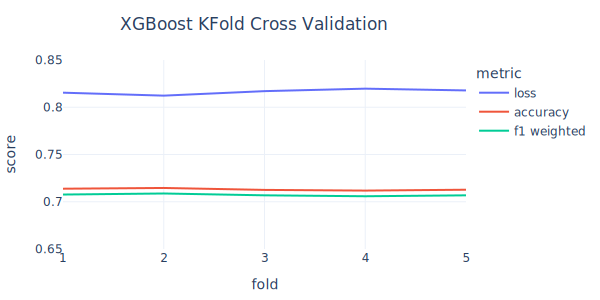

In [13]:
# plot loss, accuracy, f1 weighted in one line plot, but with plotly

import plotly.express as px

fig = px.line(
    x=list(range(1, settings.KFOLD_SPLITS+1)),
    y=[_loss, _acc, _f1_weighted],
    labels={'x':'fold', 'value':'score', 'variable':'metric'},
    title='XGBoost KFold Cross Validation',
    template='plotly_white',
    # scale y: 0-1
    range_y=[0.65, 0.85],
)
newnames = {
    'wide_variable_0': 'loss',
    'wide_variable_1': 'accuracy',
    'wide_variable_2': 'f1 weighted'
}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                legendgroup = newnames[t.name],
                hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                )
        )
# tight the layout
fig.update_layout(
    height=300, width=600,
    margin=dict(l=10, r=10, t=60, b=10),
    title_x=0.2,
)
# export to pdf
fig.write_image(settings.PLOTS_PATH / 'cls_xgb_kfold.pdf')
fig.show(renderer='svg')

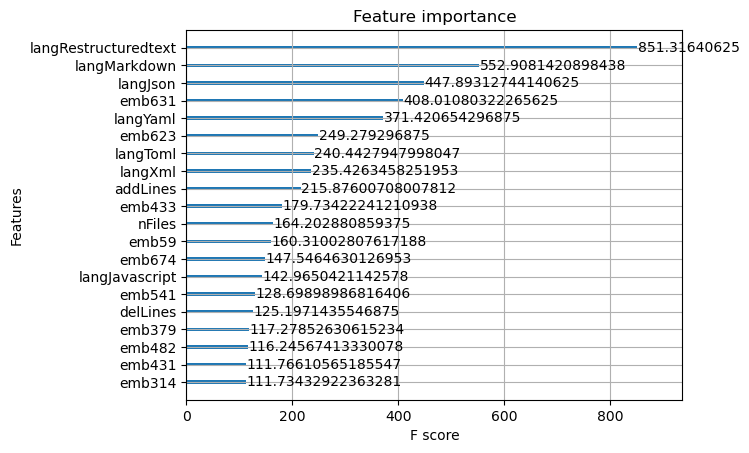

In [14]:
import matplotlib.pyplot as plt
xgb.plot_importance(clf, importance_type='gain', max_num_features=20)
plt.savefig(settings.PLOTS_PATH / 'cls_xgb_importance_gain.pdf')
plt.show()

In [15]:
# calculate shap values on GPU
# check https://xgboost.readthedocs.io/en/stable/python/gpu-examples/tree_shap.html#sphx-glr-python-gpu-examples-tree-shap-py
import shap

# model = xgb.Booster(model_file=settings.MODELS_PATH / 'cls_xgb_kfold_0.json')
# model.set_param({"device": "cuda"})
# # Compute shap values using GPU with xgboost
# model.load_model(settings.MODELS_PATH / 'cls_xgb_kfold_0.json')
# X_valid = xgb.DMatrix(X_valid, enable_categorical=True)

# # sample 10% of the validation set
_to_test = X_valid.sample(int(0.1 * len(X_valid)), random_state=settings.SEED)
_d_x_valid = xgb.DMatrix(_to_test, enable_categorical=True)

# # Compute shap interaction values using GPU
# _xgb_booster = clf.get_booster()
# shap_values = _xgb_booster.predict(_d_x_valid, pred_contribs=True)
# shap_interaction_values = _xgb_booster.predict(_d_x_valid, pred_interactions=True)

# shap will call the GPU accelerated version as long as the device parameter is set to
# "cuda"
explainer = shap.TreeExplainer(clf.get_booster())
shap_values = explainer.shap_values(_d_x_valid)
shap_values 
# visualize the first prediction's explanation
# shap.force_plot(
#     explainer.expected_value,
#     shap_values,
#     matplotlib=True,
# )

# Show a summary of feature importance
# shap.bar_plot(shap_values, _to_test)

[array([[ 3.0947251e-02,  4.6018891e-02, -6.4257368e-02, ...,
         -6.2304601e-04,  1.3246371e-03, -1.7113374e-04],
        [ 5.0261777e-02,  7.8789540e-02, -8.8336654e-02, ...,
         -4.4254895e-04, -3.5224776e-04, -6.4332933e-05],
        [ 1.1315531e-01,  5.6454033e-02,  3.4231700e-02, ...,
          1.0034401e-03, -3.9535292e-04, -1.7113374e-04],
        ...,
        [ 3.1909972e-02,  1.7489687e-02, -1.3289137e-01, ...,
         -5.9241388e-04, -2.4442968e-04, -4.3991844e-05],
        [ 1.6594811e-01, -6.7674801e-02,  3.5801720e-02, ...,
         -3.2212981e-04, -4.5625403e-04, -6.7229441e-05],
        [ 2.5466548e-02,  1.7048458e-02,  6.8308532e-02, ...,
         -2.1701318e-04,  6.5661204e-04, -4.9929837e-05]], dtype=float32),
 array([[ 3.69075909e-02,  1.23738982e-01, -2.54058894e-02, ...,
         -3.27715243e-04,  3.82927537e-04,  5.99105551e-04],
        [ 3.31897885e-02,  2.68086076e-01, -5.27646616e-02, ...,
          1.43535004e-03, -1.00022997e-03, -9.13641197e-05]

[0]	validation_0-mlogloss:2.19510
[1]	validation_0-mlogloss:2.04703
[2]	validation_0-mlogloss:1.92978
[3]	validation_0-mlogloss:1.83346
[4]	validation_0-mlogloss:1.75106
[5]	validation_0-mlogloss:1.67988
[6]	validation_0-mlogloss:1.61756
[7]	validation_0-mlogloss:1.56209
[8]	validation_0-mlogloss:1.51277
[9]	validation_0-mlogloss:1.46826
[10]	validation_0-mlogloss:1.42808
[11]	validation_0-mlogloss:1.39152
[12]	validation_0-mlogloss:1.35830
[13]	validation_0-mlogloss:1.32784
[14]	validation_0-mlogloss:1.29954
[15]	validation_0-mlogloss:1.27396
[16]	validation_0-mlogloss:1.25034
[17]	validation_0-mlogloss:1.22822
[18]	validation_0-mlogloss:1.20756
[19]	validation_0-mlogloss:1.18910
[20]	validation_0-mlogloss:1.17088
[21]	validation_0-mlogloss:1.15465
[22]	validation_0-mlogloss:1.13926
[23]	validation_0-mlogloss:1.12486
[24]	validation_0-mlogloss:1.11172
[25]	validation_0-mlogloss:1.09932
[26]	validation_0-mlogloss:1.08761
[27]	validation_0-mlogloss:1.07626
[28]	validation_0-mlogloss:1.0

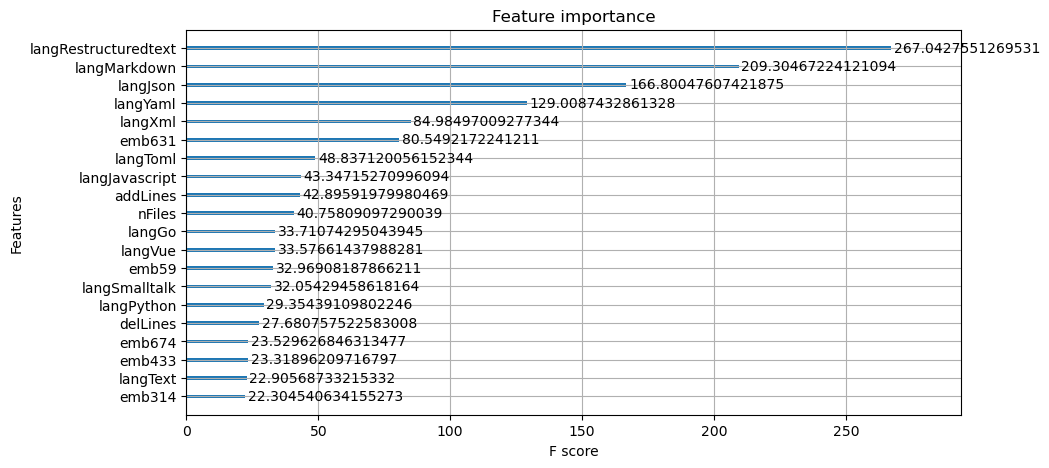

In [ ]:
# Grid search moved to a separate py file
# Can't run jupyter in the background

# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     "max_depth": [3, 5, 7, 9],
#     "learning_rate": [0.01, 0.03, 0.1, 0.3],
#     "n_estimators": [200, 300, 400, 500, 600],
# }
# clf = xgb.XGBClassifier(
#         objective="binary:logistic",
#         tree_method="hist", 
#         enable_categorical=True, 
#         device="cuda",
#         eval_metric="logloss",
#         early_stopping_rounds=10,
#         random_state=settings.SEED,
#     )
# grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=1, verbose=4, scoring="f1_weighted",)
# grid_search.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)        
# print('best params', grid_search.best_params_)
# _best_clf = grid_search.best_estimator_
# _best_clf.save_model(settings.MODELS_PATH / "xgb_gridsearch_best.json")
# print('best it', _best_clf.best_iteration, 'best score', _best_clf.best_score)
# # print perf
# y_pred = _best_clf.predict(X_test)
# print(classification_report(y_test, y_pred))
# with open(settings.MODELS_PATH / 'xgb_gridsearch_best.perf.json', 'w') as f:
#     json.dump(classification_report(y_test, y_pred, output_dict=True), f, indent=2)
# # Get feature importances
# importances = _best_clf.get_booster().get_score(importance_type="gain")
# xgb.plot_importance(importances, max_num_features=20, importance_type="gain")

import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import classification_report
import json

# best params found by grid search
BEST_PARAMS = {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500}
# BEST_PARAMS = {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 500}

_best_clf = xgb.XGBClassifier(
        objective="multi:softmax",
        tree_method="hist", 
        enable_categorical=True, 
        device="cuda",
        eval_metric="mlogloss",
        early_stopping_rounds=10,
        random_state=settings.SEED,
        **BEST_PARAMS
    )
# train
_best_clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True)
# save
_best_clf.save_model(settings.MODELS_PATH / "xgb_gridsearch_best.json")

print('best it', _best_clf.best_iteration, 'best score', _best_clf.best_score)

# print perf
y_pred = _best_clf.predict(X_test)
print(classification_report(y_test, y_pred))
with open(settings.MODELS_PATH / 'xgb_gridsearch_best.perf.json', 'w') as f:
    json.dump(classification_report(y_test, y_pred, output_dict=True), f, indent=2)

# Get feature importances
importances = _best_clf.get_booster().get_score(importance_type="gain")
plt = xgb.plot_importance(importances, max_num_features=20, importance_type="gain")
plt.figure.set_size_inches(10, 5)
plt.figure.savefig(settings.PLOTS_PATH / 'xgb_gridsearch_best_importance.pdf', bbox_inches='tight')

In [ ]:
# plot shap
import shap

_to_test = X_valid.sample(int(0.1 * len(X_valid)), random_state=settings.SEED)
explainer = shap.TreeExplainer(_best_clf)
shap_values = explainer.shap_values(_to_test)

shap.summary_plot(
    shap_values, 
    _to_test, 
    plot_type="bar", 
    class_names=settings.categories.conventional_commits
)

NameError: name '_best_clf' is not defined

In [ ]:
# let's create some baselines

# 1. a naive multicategory classifier

# use a linear SVM
import os
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# reference: https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html
class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

# standardize the data
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

# train the model
clf = NaivelyCalibratedLinearSVC(C=1.0, max_iter=100, random_state=settings.SEED)

clf.fit(X_train, y_train)

# evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
with open(settings.MODELS_PATH / 'cls_naive_linear_svc.perf.json', 'w') as f:
    json.dump(classification_report(y_test, y_pred, output_dict=True), f)

# save the model
import joblib
joblib.dump(clf, settings.MODELS_PATH / 'cls_naive_linear_svc.joblib')

/raid/hrz/smartdraft/.pixi/envs/default/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/raid/hrz/smartdraft/.pixi/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/raid/hrz/smartdraft/.pixi/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/raid/hrz/smartdraft/.pixi/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

              precision    recall  f1-score   support

           0       0.29      0.02      0.04      4722
           1       0.55      0.76      0.64     40757
           2       0.43      0.06      0.10      1936
           3       0.69      0.55      0.61     13885
           4       0.55      0.43      0.48     23087
           5       0.60      0.65      0.62     44925
           6       0.42      0.03      0.05       834
           7       0.27      0.11      0.15      7338
           8       0.00      0.00      0.00       138
           9       0.12      0.01      0.01       780
          10       0.38      0.47      0.42      4615

    accuracy                           0.56    143017
   macro avg       0.39      0.28      0.28    143017
weighted avg       0.55      0.56      0.54    143017



/raid/hrz/smartdraft/.pixi/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/raid/hrz/smartdraft/.pixi/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/raid/hrz/smartdraft/.pixi/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



['../models/cls_gte_xgb/cls_naive_linear_svc.joblib']

In [ ]:
# 2. a xgb classifier without text features

X_train, y_train = ds_train.drop(columns=['type']), ds_train['type']
X_test, y_test = ds_test.drop(columns=['type']), ds_test['type']
X_valid, y_valid = ds_valid.drop(columns=['type']), ds_valid['type']

clf = xgb.XGBClassifier(
        objective="multi:softmax",
        tree_method="hist", 
        enable_categorical=True, 
        device="cuda" if settings.TORCH_DEVICE.type == 'cuda' else "cpu",
        eval_metric="mlogloss",
        random_state=settings.SEED,
        early_stopping_rounds=10,
    )
clf.fit(
    X_train.drop(columns=df_embs.columns), y_train,
    eval_set=[(X_test.drop(columns=df_embs.columns), y_test)],
    verbose=True,
)

# save the model
clf.save_model(settings.MODELS_PATH / 'cls_xgb_no_text.json')
# save perf
y_pred = clf.predict(X_test.drop(columns=df_embs.columns))
print(classification_report(y_test, y_pred))
with open(settings.MODELS_PATH / 'cls_xgb_no_text.perf.json', 'w') as f:
    json.dump(classification_report(y_test, y_pred, output_dict=True), f, indent=2)

[0]	validation_0-mlogloss:1.92839
[1]	validation_0-mlogloss:1.73180
[2]	validation_0-mlogloss:1.60382
[3]	validation_0-mlogloss:1.51128
[4]	validation_0-mlogloss:1.44264
[5]	validation_0-mlogloss:1.38919
[6]	validation_0-mlogloss:1.34602
[7]	validation_0-mlogloss:1.31141
[8]	validation_0-mlogloss:1.28238
[9]	validation_0-mlogloss:1.25939
[10]	validation_0-mlogloss:1.23955
[11]	validation_0-mlogloss:1.22118
[12]	validation_0-mlogloss:1.20776
[13]	validation_0-mlogloss:1.19409
[14]	validation_0-mlogloss:1.18312
[15]	validation_0-mlogloss:1.17327
[16]	validation_0-mlogloss:1.16398
[17]	validation_0-mlogloss:1.15512
[18]	validation_0-mlogloss:1.14905
[19]	validation_0-mlogloss:1.14200
[20]	validation_0-mlogloss:1.13590
[21]	validation_0-mlogloss:1.12961
[22]	validation_0-mlogloss:1.12484
[23]	validation_0-mlogloss:1.11952
[24]	validation_0-mlogloss:1.11525
[25]	validation_0-mlogloss:1.11037
[26]	validation_0-mlogloss:1.10718
[27]	validation_0-mlogloss:1.10398
[28]	validation_0-mlogloss:1.1

In [ ]:
# a xgb classifier with only text features

clf = xgb.XGBClassifier(
        objective="multi:softmax",
        tree_method="hist", 
        enable_categorical=True, 
        device="cuda",
        eval_metric="mlogloss",
        random_state=settings.SEED,
        early_stopping_rounds=10,
    )
clf.fit(
    X_train[df_embs.columns], y_train,
    eval_set=[(X_test[df_embs.columns], y_test)],
    verbose=True,
)

# save the model
clf.save_model(settings.MODELS_PATH / 'cls_xgb_only_text.json')
# save perf
y_pred = clf.predict(X_test[df_embs.columns])
print(classification_report(y_test, y_pred))
with open(settings.MODELS_PATH / 'cls_xgb_only_text.perf.json', 'w') as f:
    json.dump(classification_report(y_test, y_pred, output_dict=True), f, indent=2)

[0]	validation_0-mlogloss:2.01022
[1]	validation_0-mlogloss:1.81914
[2]	validation_0-mlogloss:1.69171
[3]	validation_0-mlogloss:1.59904
[4]	validation_0-mlogloss:1.52960
[5]	validation_0-mlogloss:1.47451
[6]	validation_0-mlogloss:1.43079
[7]	validation_0-mlogloss:1.39582
[8]	validation_0-mlogloss:1.36670
[9]	validation_0-mlogloss:1.34287
[10]	validation_0-mlogloss:1.32263
[11]	validation_0-mlogloss:1.30490
[12]	validation_0-mlogloss:1.28980
[13]	validation_0-mlogloss:1.27675
[14]	validation_0-mlogloss:1.26517
[15]	validation_0-mlogloss:1.25491
[16]	validation_0-mlogloss:1.24571
[17]	validation_0-mlogloss:1.23767
[18]	validation_0-mlogloss:1.23051
[19]	validation_0-mlogloss:1.22392
[20]	validation_0-mlogloss:1.21826
[21]	validation_0-mlogloss:1.21268
[22]	validation_0-mlogloss:1.20758
[23]	validation_0-mlogloss:1.20299
[24]	validation_0-mlogloss:1.19863
[25]	validation_0-mlogloss:1.19476
[26]	validation_0-mlogloss:1.19077
[27]	validation_0-mlogloss:1.18713
[28]	validation_0-mlogloss:1.1